In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print( device )
print(torch.__version__)

cuda
2.6.0+cu118


In [91]:
path = os.path.expanduser( '~/SimCLR/runs/Apr13_14-18-24_j-leelab1.mae.ncsu.edu/checkpoint_0200.pth.tar' )
checkpoint = torch.load(path, map_location=device)
state_dict = checkpoint['state_dict']

# Model: ResNet18 !
model = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)
model.eval()

/home/hjang4/anaconda3/envs/simclr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hjang4/anaconda3/envs/simclr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [92]:
# Eliminate base fc layer ... feature extractor, f(.)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.to(device)
feature_extractor.eval()

dataset_path = os.path.expanduser( '~/SimCLR/datasets' )
stl10_test = torchvision.datasets.STL10(root=dataset_path, split='test', download=False, transform=transforms.ToTensor())
dataset_loader = torch.utils.data.DataLoader(stl10_test, batch_size=int(len(stl10_test)/10), shuffle=False)

images, labels = next(iter(dataset_loader))
labels = labels.cpu().numpy()
images = images.to(device)

print( len(dataset_loader) )
# print( len(stl10_test) )

10


In [93]:
# Representation vector calculated from feature_extractor, ResNet18 (avgpool + flatten)
with torch.no_grad():
    features = feature_extractor(images)  # shape: (batch, feature_dim, 1, 1)
    features = features.view(features.size(0), -1)  # shape: (batch, feature_dim)
print(features.shape)

torch.Size([800, 512])


In [94]:
# Dimension reduciton using kernel PCA --> Reduce to 200-dim space !

features = features.cpu().numpy()

# Linear Kernel
kpca_lin = KernelPCA(n_components=200, kernel='linear', random_state=42)
features_kpca_lin = kpca_lin.fit_transform(features)

# Polynomial Kernel
kpca_poly = KernelPCA(n_components=200, kernel='poly', gamma=0.03, random_state=42)
features_kpca_poly = kpca_poly.fit_transform(features)

# RBF Kernel
kpca_rbf = KernelPCA(n_components=200, kernel='rbf', gamma=0.03, random_state=42)
features_kpca_rbf = kpca_rbf.fit_transform(features)

# Sigmoid Kernel
kpca_sig = KernelPCA(n_components=200, kernel='sigmoid', gamma=0.03, random_state=42)
features_kpca_sig = kpca_sig.fit_transform(features)

# Cosine similarity Kernel
kpca_cos = KernelPCA(n_components=200, kernel='cosine', random_state=42)
features_kpca_cos = kpca_cos.fit_transform(features)


In [98]:
tsne = TSNE(n_components=3, random_state=42, perplexity=50, learning_rate=10)

features_tsne = tsne.fit_transform(features)
features_tsne_lin = tsne.fit_transform(features_kpca_lin)
features_tsne_poly = tsne.fit_transform(features_kpca_poly)
features_tsne_rbf = tsne.fit_transform(features_kpca_rbf)
features_tsne_sig = tsne.fit_transform(features_kpca_sig)
features_tsne_cos = tsne.fit_transform(features_kpca_cos)

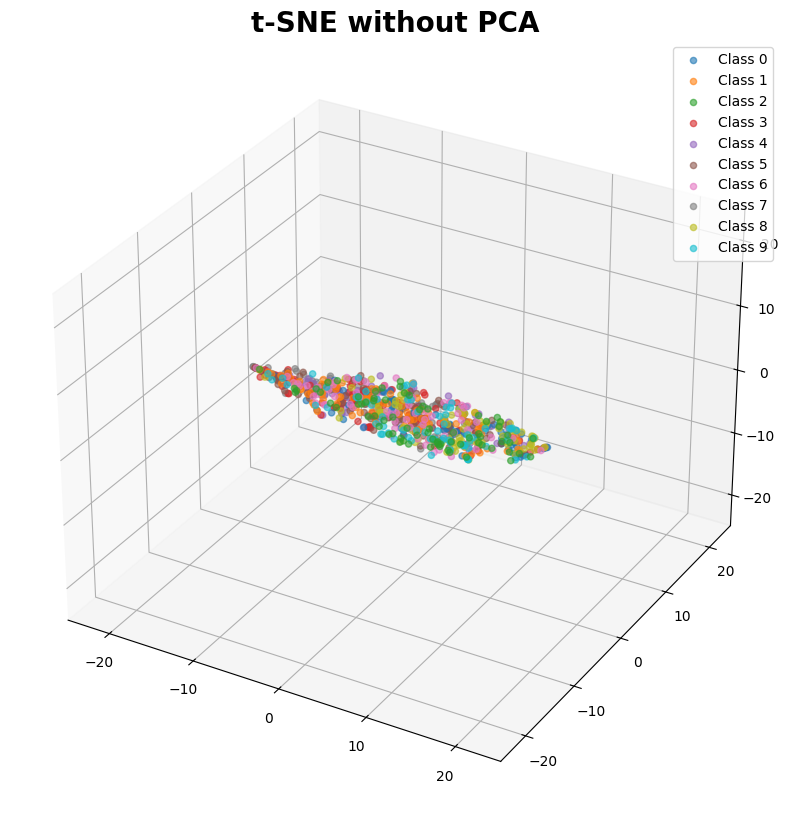

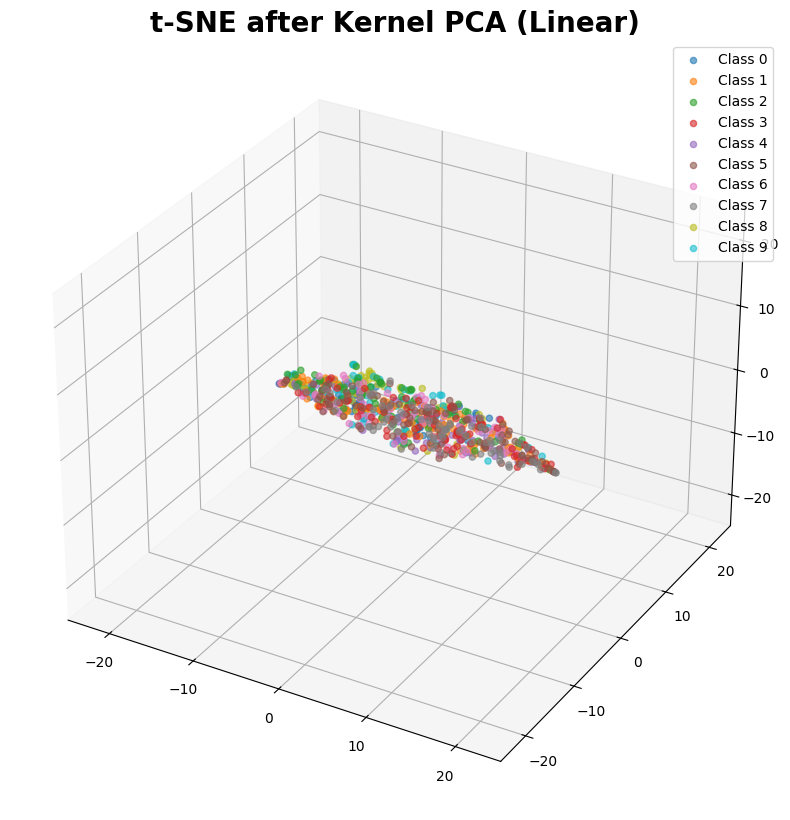

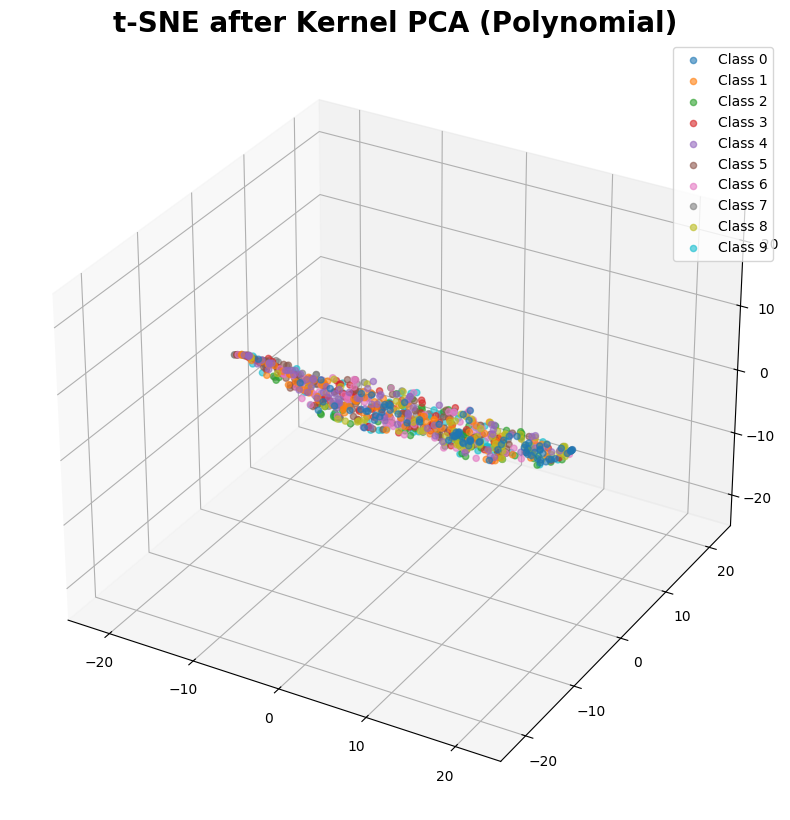

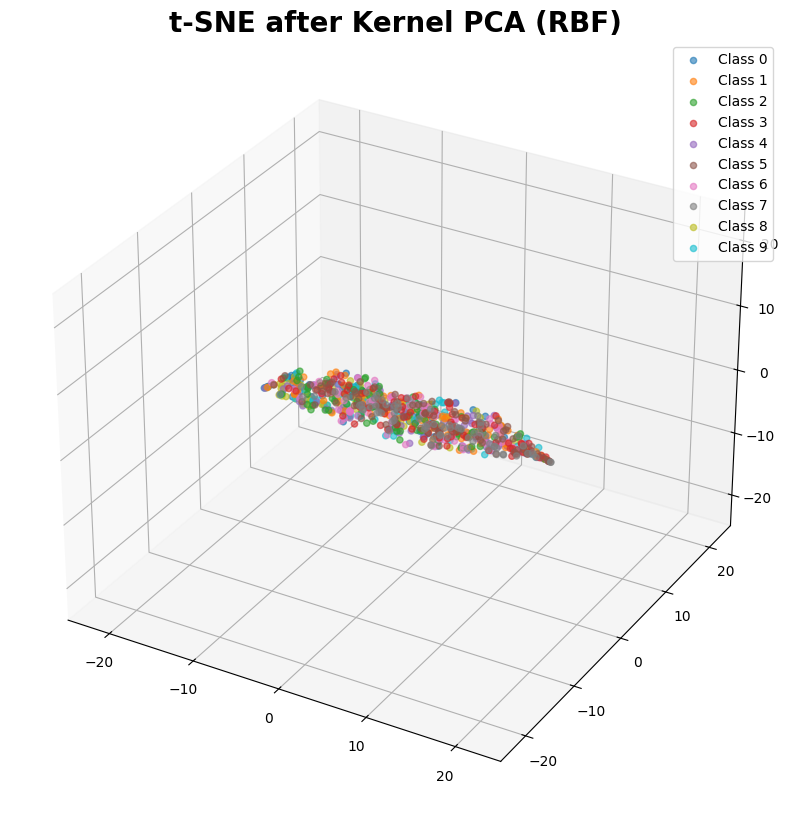

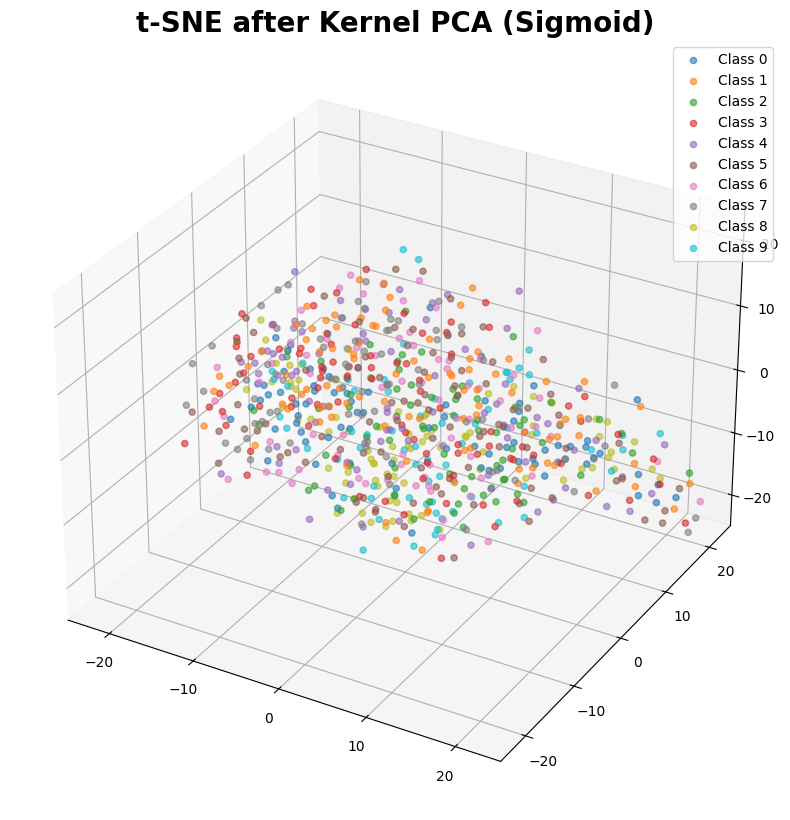

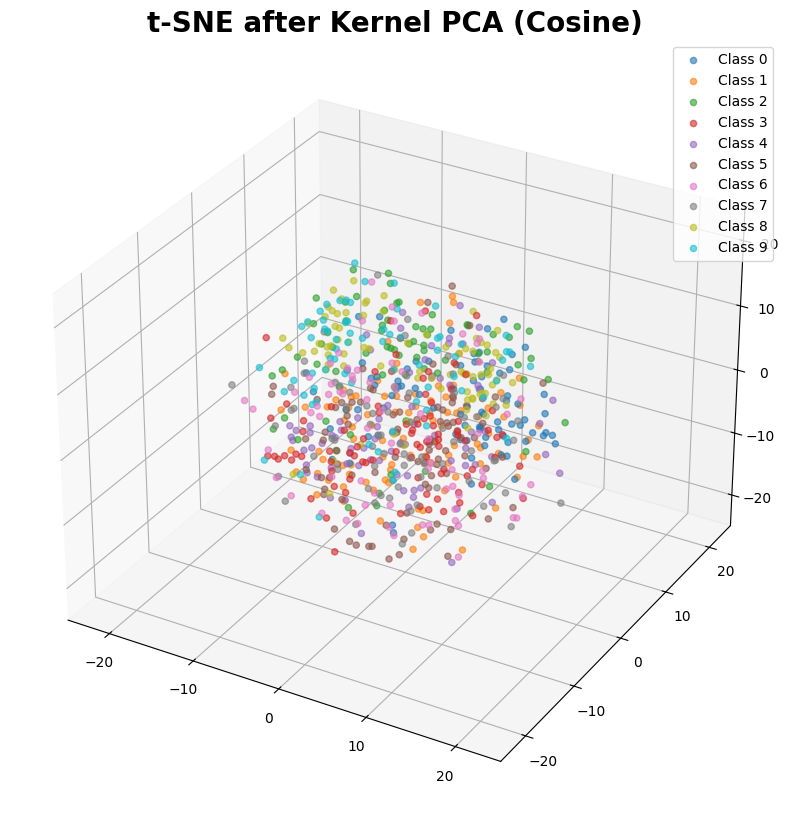

In [102]:
def Visualize(features_tsne, title):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(len(set(labels))):
        idx = labels == i
        # plt.scatter(features_tsne[idx, 0], features_tsne[idx, 1], label=f"Class {i}", alpha=0.6)
        ax.scatter(
            features_tsne[idx, 0], features_tsne[idx, 1], features_tsne[idx, 2],
            label=f"Class {i}", alpha=0.6
        )
    # plt.legend()
    # plt.title(title)
    ax.legend()
    ax.set_xlim( [-25, 25] )
    ax.set_ylim( [-25, 25] )
    ax.set_zlim( [-25, 25] )
    ax.set_title(title, fontsize=20, fontweight='bold')
    plt.savefig( title+".jpg" )
    plt.show()

Visualize( features_tsne, "t-SNE without PCA" )
Visualize( features_tsne_lin, "t-SNE after Kernel PCA (Linear)" )
Visualize( features_tsne_poly, "t-SNE after Kernel PCA (Polynomial)" )
Visualize( features_tsne_rbf, "t-SNE after Kernel PCA (RBF)" )
Visualize( features_tsne_sig, "t-SNE after Kernel PCA (Sigmoid)" )
Visualize( features_tsne_cos, "t-SNE after Kernel PCA (Cosine)" )